# Logistic Regression - Binary Classification

## Base
Let us implement logistic regression from scratch. Logistic regression is commonly used as a binary classification model. It is similar to linear regression in that we take a linear combination of the input features. But then we feed the output through a logistic function, particularly sigmoid $\frac{1}{1+e^{-z}}$, so that the actual output is bounded. For classification, we can take the bounded output between 0 and 1 and for example, classify it as class 1 if below the threshold 0.5, otherwise class 2.  

More specifically, let $X$ be a dataset with $N$ observations each with $k$ features. For a feature $x = [x_1, x_2, ..., x_k]$ there is a corresponding scalar target $y$ which could take on a value of $0$ or $1$. Then similar to linear regression, first take a linear combination of the features

$$z = B_0*x_0 + B_1*x_1 + ... + B_k*x_k = B^T \cdot x$$

where $x_0 = 1$ per notation. 

Then, we apply the sigmoid function to $z$ to get

$$h(B) = \frac{1}{1+e^{-z}} = \frac{1}{1+e^{-B_0*x_0 + B_1*x_1 + ... + B_k*x_k}}$$

We want to find $B = [B_0, B_1, ..., B_k]$ that best approximates $y$. 

## Cost function
Recall the likelihood is the probability of the data given the weights on the features, $B$. So we want to estimate the parameters by maximize the likelihood function. In this case

$$ p(Y| X, B) = \prod_{i=1}^{N} p(y_i | x_i, B)$$

Now we define a loss function so that minimizing it will maximize the likelihood function. Let our loss function be the negative log of the likelihood function. Since log is a monotonically increasing function, find the minimum of the negative log likelihood function will be the same as finding the maximum of the likelihood function. So we define our loss function to be

$$ J(B) = -\sum_{i=1}^{N} log(p(y_i | x_i, B))$$

What does this mean in the case of binary classification? Let $p(y)$ be the probability that $y$ is of class 1, WLOG when $y = 1$ Then $1-p(y)$ is the probability that $y$ is of class 2, i.e. $y = 0$. Then we can write the probability explicitly for both classes in one line as 

$$log(p(y_i | x_i, B)) = y_i*log(p(y_i)) + (1-y_i)*log(1-p(y_i))$$

Now, $p(y) = h$. Thus our loss function is

$$ J(B) = -\sum_{i=1}^{N} y_i*log(h(B)) + (1-y_i)*log(1-h(B))\\ 
 = \sum_{i=1}^{N} -y_i * (log(h) - log(1-h)) - log(1-h)\\
 = \sum_{i=1}^{N} -y_i * log(\frac{h}{1-h}) - log(1-h)$$ 
 
Now,

$$ log(1-h) = log(\frac{1}{1+e^{-z}}) = -log(1+e^z)$$
and

$$ \frac{h}{1-h} = \frac{1}{1+e^{-z}} * \frac{1 + e^{-z}}{e^{-z}} = e^z$$

Therefore we have

$$ J(B) = \sum_{i=1}^{N} -y_i * z + log(1+e^z) \\
= \sum_{i=1}^{N} -y_i B^T x_i + log(1+e^{B^T x_i})$$

## Gradient Descent

Now that we have a loss function we'd like to minimize, we do this using gradient descent as we did with linear regression. 

Start by initializing the weights, $B$, to something random, say 0. Then we calculate the gradient of our loss function given this $B$ and take the average over all data points. Since the gradient points in the direction of the steepest ascend, we then multiply it by the learning rate and update the weights by subtracting this value from it. 

The gradient is 

$$\frac{\partial J}{\partial B} = \sum_{i=1}^{N} -y_i x_i + \frac{e^{B^T x_i} x_i}{1+e^{B^T x_i}}\\
= - \sum_{i=1}^{N} x_i (y_i - \frac{1}{1+e^{-B^T x_i}})\\
= - \sum_{i=1}^{N} x_i (y_i - \frac{1}{1+e^{-z}})\\
= - \sum_{i=1}^{N} x_i (y_i - h(B))$$

Finally we update the weights 

$$B = B - lr *  (- \frac{1}{N}\sum_{i=1}^{N} x_i (y_i - h(B)))$$

Great, so let's write some code. We break it down into the following steps:
1. Normalize data
2. Initialize weights
3. Predict, cost and gradient functions
4. Update weights
5. Train 
6. Compare to sklearn 

In [1]:
%matplotlib inline
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the breasts cancer dataset
breast_cancer = datasets.load_breast_cancer()

In [7]:
print(breast_cancer.target.shape)
print(breast_cancer.data.shape)

(569,)
(569, 30)


In [8]:
X = breast_cancer['data']
y = breast_cancer['target'].reshape(569, 1)

## Normalize Data

In [12]:
def normalize(features):
    # features here is a (442, 10) array, need to transpose to look at each of the 
    # 30 features individually 
    for feature in features.T:
        m = feature.mean()
        rng = feature.max() - feature.min()
        feature -= m
        feature /= rng
        
    return features

In [13]:
X_normal = normalize(X)

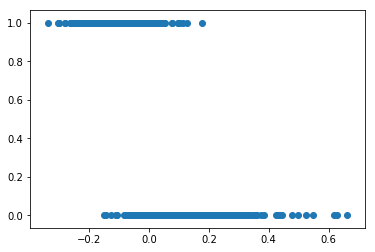

In [15]:
plt.scatter(X_normal[:, 0], y)

In [22]:
# To make things easier, append 1 as feature x_0
bias = np.ones(shape=(len(X_normal),1))
features = np.append(bias, X_normal, axis=1)

## Initialize Weights

In [20]:
def initialize_weights(features):
    N = features.shape[1]
    return [[0] for _ in range(N)]

In [25]:
weights = initialize_weights(features)

## Predict, loss, gradient

In [77]:
def predict_prob(features, weights):
    z = np.dot(features, weights)
    h = 1 / (1+ np.exp(-z))
    return h

In [78]:
def predict(features, weights, threshold=0.5):
    return predict_prob(features, weights) >= threshold

In [79]:
# This makes sense, if the weights are 0, then e^z = e^0 = 1 thus h = 1/2
predict(features, weights)[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

In [80]:
predict_prob(features, weights)[:5]

array([[ 0.5],
       [ 0.5],
       [ 0.5],
       [ 0.5],
       [ 0.5]])

In [81]:
def loss_func(features, targets, weights):
    predicted_prob = predict_prob(features, weights)
    loss = ((-targets * np.log(predicted_prob) - (1-targets)*np.log(1-predicted_prob))).mean()
    return loss

In [82]:
loss_func(features, y, weights)

0.69314718055994529

## Update weights

In [83]:
def update_weights(features, targets, weights, lr=0.01):
    prob = predict_prob(features, weights)
    N = features.shape[0]
    gradient = np.dot(-features.T, (targets-prob))/N
    weights -= lr * gradient
    return weights

In [84]:
update_weights(features, y, weights)

array([[  1.27416520e-03],
       [ -5.88180473e-04],
       [ -2.91723560e-04],
       [ -6.02383474e-04],
       [ -5.11245082e-04],
       [ -2.19917739e-04],
       [ -4.66807019e-04],
       [ -6.28323464e-04],
       [ -7.23516640e-04],
       [ -2.21049250e-04],
       [  9.22163748e-06],
       [ -2.75117437e-04],
       [  4.89016181e-06],
       [ -2.55938503e-04],
       [ -2.25021545e-04],
       [  3.30425540e-05],
       [ -1.90366749e-04],
       [ -9.34308877e-05],
       [ -2.30391580e-04],
       [  3.66448688e-06],
       [ -3.44329109e-05],
       [ -6.44912912e-04],
       [ -3.61559333e-04],
       [ -6.32924633e-04],
       [ -4.96042225e-04],
       [ -3.06979504e-04],
       [ -4.35799731e-04],
       [ -5.30952536e-04],
       [ -8.65918425e-04],
       [ -2.45248161e-04],
       [ -1.85341967e-04]])

## Train

In [87]:
def logreg_fit(features, targets, lr=0.01, iterations=1000, return_loss=True):
    # assume we have normalized features
    
    # initialize weights
    weights = initialize_weights(features)
    
    # keep track of loss
    loss = []
    loss.append(loss_func(features, targets, weights))
    
    for i in range(iterations):
        weights = update_weights(features, targets, weights, lr)
        loss.append(loss_func(features, targets, weights))
    if not return_loss:
        return weights, _
    return weights, loss

In [89]:
final = logreg_fit(features, y)

## Evaluation

In [106]:
def accuracy(features, targets, weights):
    preds = predict(features, weights)
    # accuracy
    return (preds == targets).mean()

In [107]:
accuracy(features, y, final[0])

0.90509666080843587

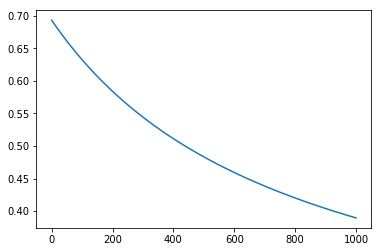

In [99]:
plt.plot(final[1])

In [101]:
more_it = logreg_fit(features, y, iterations=10000)

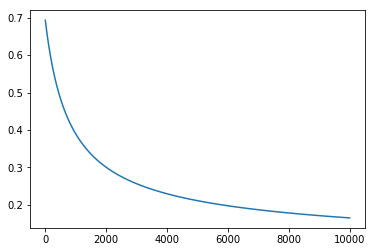

In [103]:
plt.plot(more_it[1])

In [108]:
accuracy(features, y, more_it[0])

0.95254833040421794

## From sklearn

In [109]:
from sklearn.linear_model import LogisticRegression

In [112]:
logreg = LogisticRegression()

logreg.fit(features, y)

breast_cancer_predict = logreg.predict(features)

/home/ohstephanies/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ohstephanies/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [115]:
print("logistic regression coefficients: ", logreg.coef_)
print("sklearn accuracy: %.2f" %logreg.score(features, y))

logistic regression coefficients:  [[ 0.33348792 -1.89323684 -1.71455598 -1.85748881 -1.60561734 -0.65134699
  -0.33372615 -1.43868774 -2.14236338 -0.54924845  0.97520857 -1.28876322
  -0.04110554 -0.9934522  -0.85346139 -0.06285718  0.65945602  0.27284232
  -0.26420715  0.22434364  0.63911482 -2.43439459 -2.35644136 -2.22510782
  -1.76431033 -1.57714803 -0.77639265 -1.38118315 -2.72594484 -1.33593214
  -0.33594566]]
sklearn accuracy: 0.97


In [122]:
more_it[0]

(31, 1)

In [118]:
## compare coefficients

In [123]:
mine = {i: more_it[0][i][0] for i in range(31)}
mine

{0: 0.67338823707735718,
 1: -1.5155732357910663,
 2: -1.0016099530670677,
 3: -1.5192780836764801,
 4: -1.2817821157471727,
 5: -0.46552300724346335,
 6: -0.77510914091979022,
 7: -1.257848935316547,
 8: -1.6872069431740235,
 9: -0.43685979968222405,
 10: 0.44097702172192116,
 11: -0.7019080453931551,
 12: 0.011855134724343592,
 13: -0.60356668671721858,
 14: -0.5382878656662804,
 15: 0.10450297982479176,
 16: -0.01631750307394603,
 17: 0.024941427430147777,
 18: -0.33231185680681968,
 19: 0.12181033999379433,
 20: 0.22266809089184797,
 21: -1.7293129677088608,
 22: -1.3063285168394561,
 23: -1.6452931684563283,
 24: -1.2781142843119448,
 25: -0.89885011457039521,
 26: -0.88235615449187532,
 27: -1.1332934344494499,
 28: -2.1209986169017565,
 29: -0.73263102144529191,
 30: -0.30936125245447799}

In [134]:
sklearns = {i: (logreg.coef_)[0][i] for i in range(31)}
sklearns

{0: 0.33348791727830268,
 1: -1.893236835654867,
 2: -1.7145559848091145,
 3: -1.8574888052546197,
 4: -1.6056173370983078,
 5: -0.65134698849490469,
 6: -0.33372614879751517,
 7: -1.4386877413488137,
 8: -2.1423633808416778,
 9: -0.54924845015359625,
 10: 0.9752085657117523,
 11: -1.2887632231843476,
 12: -0.041105537822651736,
 13: -0.99345219578221755,
 14: -0.85346139010265321,
 15: -0.062857177890708174,
 16: 0.65945602133699699,
 17: 0.27284231578295109,
 18: -0.26420715488927532,
 19: 0.22434364002740106,
 20: 0.63911482364309469,
 21: -2.4343945892055365,
 22: -2.3564413569694844,
 23: -2.2251078185098798,
 24: -1.7643103269804428,
 25: -1.5771480312742374,
 26: -0.77639265014247127,
 27: -1.3811831549855618,
 28: -2.7259448439522105,
 29: -1.3359321437069498,
 30: -0.33594566373707613}

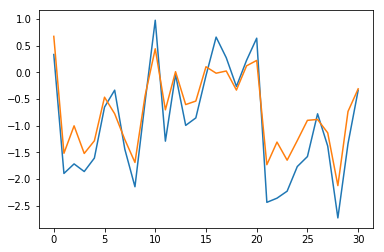

In [137]:
plt.plot(logreg.coef_[0])
plt.plot(more_it[0])